In [1]:
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from utils.GNN_data import *
from utils.GNN_architecture import GIN
from utils.train_model import train_model
from utils.evaluate_model import *

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--batch_num', type=int, default=64, help='batch size') 
parser.add_argument('--epoch_num', type=int, default=200, help='Epoch number') 
parser.add_argument('--cover_interval', type=int, default=20, help='Cover interval')
parser.add_argument('--overlap', type=float, default=0.3, help='cover overlap')
parser.add_argument('--save_model_dir', type=str, default='./saved_model', help='saved GNN model directory')
args = parser.parse_args([])
#2 features
#epoch_num = 200 -> converge
#running time more than 30 mins
#drop out = 0.5

In [3]:

def load_inp_data(file_path, label):
    nodes, edges = [], []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

        node_section = False
        element_section = False

        for line in lines:
            line = line.strip()

            if "*Node" in line:
                node_section = True
                element_section = False
                continue

            if "*Element" in line:
                node_section = False
                element_section = True
                continue

            # Skip invalid lines like "*Nset" or "*Elset"
            if "*Nset" in line or "*Elset" in line:
                node_section = False
                element_section = False
                continue

            if node_section:
                parts = line.split(',')
                if len(parts) >= 3:
                    try:
                        x, y = float(parts[1].strip()), float(parts[2].strip())
                        nodes.append([x, y])
                    except ValueError:
                        continue

            if element_section:
                parts = line.split(',')
                if len(parts) >= 3 and parts[0].strip().isdigit() and parts[1].strip().isdigit() and parts[2].strip().isdigit():
                    start, end = int(parts[1].strip()) - 1, int(parts[2].strip()) - 1  # Convert 1-indexed to 0-indexed
                    
                    if start == end:
                        continue
                    
                    # Ensure indices are within valid range
                    if start < len(nodes) and end < len(nodes):
                        edges.append([start, end])
                    else:
                        print(f"Skipping invalid edge ({start+1}, {end+1}) in {file_path}")

    node_tensor = torch.tensor(nodes, dtype=torch.float)
    edge_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

    data = Data(x=node_tensor, edge_index=edge_tensor, E=np.float64(label * 200.00))
    return data

# Data loading

In [4]:
import os
from glob import glob

folder_list = ['Kagome', 'Hexagonal', 'Demi-A', 'Demi-B', 'Demi-C']
base_path = '.'  

dataset = []

for folder in folder_list:
    results_path = os.path.join(base_path, folder, 'Results.txt')
    inp_folder = os.path.join(base_path, folder, 'inp_files')

    # Parse Results.txt in the current folder
    file_labels = {}
    with open(results_path, 'r') as file:
        for line in file:
            if line.strip() == "" or "E/Es" in line:
                continue
            try:
                file_name, label = line.strip().split(', ')
                filename = file_name.strip().split('.')[0]
                label = float(label)
                file_labels[filename] = label
            except ValueError:
                print(f"[{folder}] Skipping invalid line: {line.strip()}")

    # Load each corresponding .inp file
    for file, label in file_labels.items():
        file_path = os.path.join(inp_folder, f"{file}.inp")
        if os.path.exists(file_path):
            data = load_inp_data(file_path, label)
            if data is not None:
                dataset.append(data)
        else:
            print(f"[{folder}] Missing file: {file_path}")

In [5]:
dataset

[Data(x=[104, 2], edge_index=[2, 180], E=3.3342561035200005),
 Data(x=[104, 2], edge_index=[2, 180], E=3.31936621094),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3175781250000003),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3117568359400003),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3090815429599996),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3022961425800004),
 Data(x=[104, 2], edge_index=[2, 180], E=3.31983398438),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3201633300799998),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3031911621),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3095705566399998),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3185014648399997),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3280244140599997),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3147871093799997),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3128129882799997),
 Data(x=[104, 2], edge_index=[2, 180], E=3.3111208496),
 Data(x=[104, 2], edge_index=[2, 180], E=3.31814355468),
 Data(x=[104, 2], edge_index=[2, 18

In [6]:
batch_size = args.batch_num
epoch_num = args.epoch_num 
learning_rate = 0.001
overlap=args.overlap

# Check if the graph data is directed or undirected. For this study, undirected edges are used.
all_undirected_before = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (before conversion): {all_undirected_before}')  # True if all are undirected, False otherwise

# Convert all graphs in the dataset to undirected
dataset = [make_undirected(data) for data in dataset]

# Re-check if all graphs are now undirected
all_undirected_after = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (after conversion): {all_undirected_after}')  # True if all are undirected, False otherwise

dataset = normalize_planar_info(dataset)

# Split dataset for train/validation/test
train_loader, test_loader, valid_loader = prepare_dataset(dataset, batch_size, train_percentage=0.80, test_percentage=0.1)

Graphs are undirected (before conversion): False
Graphs are undirected (after conversion): True
Number of training graphs: 4004
Number of test graphs: 500
Number of vali graphs: 501


In [7]:
dataset[0]

Data(x=[104, 2], edge_index=[2, 360], E=3.3342561035200005)

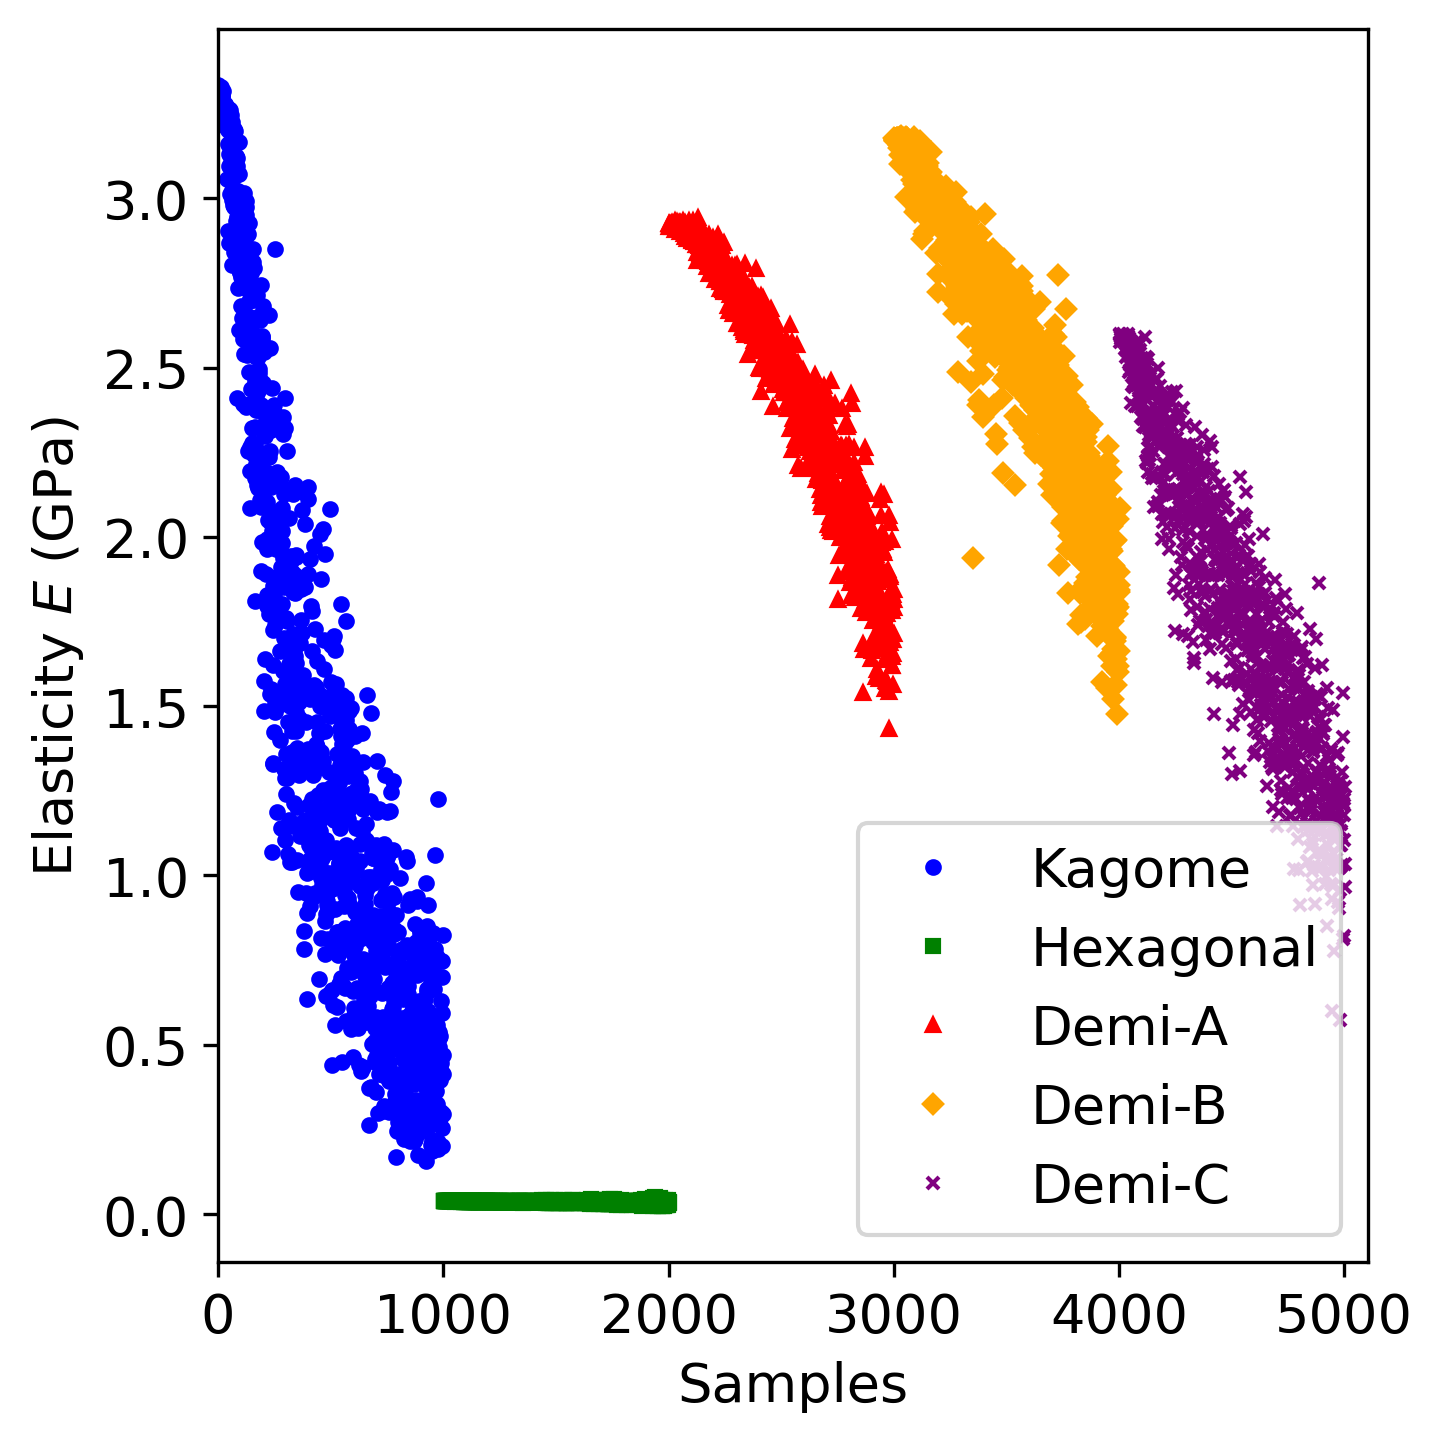

In [8]:
E_vals = [data.E for data in dataset]

plt.figure(figsize=(5,5), dpi=300) 

plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 13

labels = ['Kagome', 'Hexagonal', 'Demi-A', 'Demi-B', 'Demi-C']
markers = ['o', 's', '^', 'D', 'x']  # circle, square, triangle, diamond, cross
colors = ['blue', 'green', 'red', 'orange', 'purple']

size = 1001
for i in range(5):
    start = i * size
    end = (i + 1) * size
    x = range(start, end)
    y = E_vals[start:end]
    
    plt.plot(x, y, linestyle='none', marker=markers[i], color=colors[i],
             markersize=3, label=labels[i])

plt.ylabel(r'Elasticity $E$ (GPa)')
plt.xlabel('Samples')
plt.xlim([0,5*size+100])
plt.legend()
plt.tight_layout() 

# GNN architecture

In [9]:
# Define the model, optimizer, and loss function

no_node_feature = dataset[0].x.shape[1]
model = GIN(dim_h=64, node_feature=no_node_feature)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.MSELoss()
print(model)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Use GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=192, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=128, bias=True)
  (lin4): Linear(in_features=1

/root/miniconda3/envs/GNN_ElasticModulus_Prediction/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training

In [10]:
train_losses, test_losses, R2_trainings, R2_tests, best_state_dict = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device=device, num_epochs=epoch_num)

Epoch [1], Loss[Train: 6.358, Test: 0.511], R2[Train: -4.809, Test: 0.525]
Epoch [2], Loss[Train: 0.352, Test: 0.238], R2[Train: 0.678, Test: 0.779]
Epoch [3], Loss[Train: 0.286, Test: 0.210], R2[Train: 0.739, Test: 0.805]
Epoch [4], Loss[Train: 0.302, Test: 0.322], R2[Train: 0.724, Test: 0.700]
Epoch [5], Loss[Train: 0.337, Test: 0.211], R2[Train: 0.692, Test: 0.804]
Epoch [6], Loss[Train: 0.261, Test: 0.231], R2[Train: 0.762, Test: 0.786]
Epoch [7], Loss[Train: 0.299, Test: 0.403], R2[Train: 0.727, Test: 0.626]
Epoch [8], Loss[Train: 0.251, Test: 0.196], R2[Train: 0.771, Test: 0.818]
Epoch [9], Loss[Train: 0.254, Test: 0.226], R2[Train: 0.768, Test: 0.790]
Epoch [10], Loss[Train: 0.215, Test: 0.195], R2[Train: 0.803, Test: 0.819]
Epoch [11], Loss[Train: 0.362, Test: 0.268], R2[Train: 0.669, Test: 0.751]
Epoch [12], Loss[Train: 0.252, Test: 0.249], R2[Train: 0.770, Test: 0.768]
Epoch [13], Loss[Train: 0.207, Test: 0.210], R2[Train: 0.811, Test: 0.805]
Epoch [14], Loss[Train: 0.215, Te

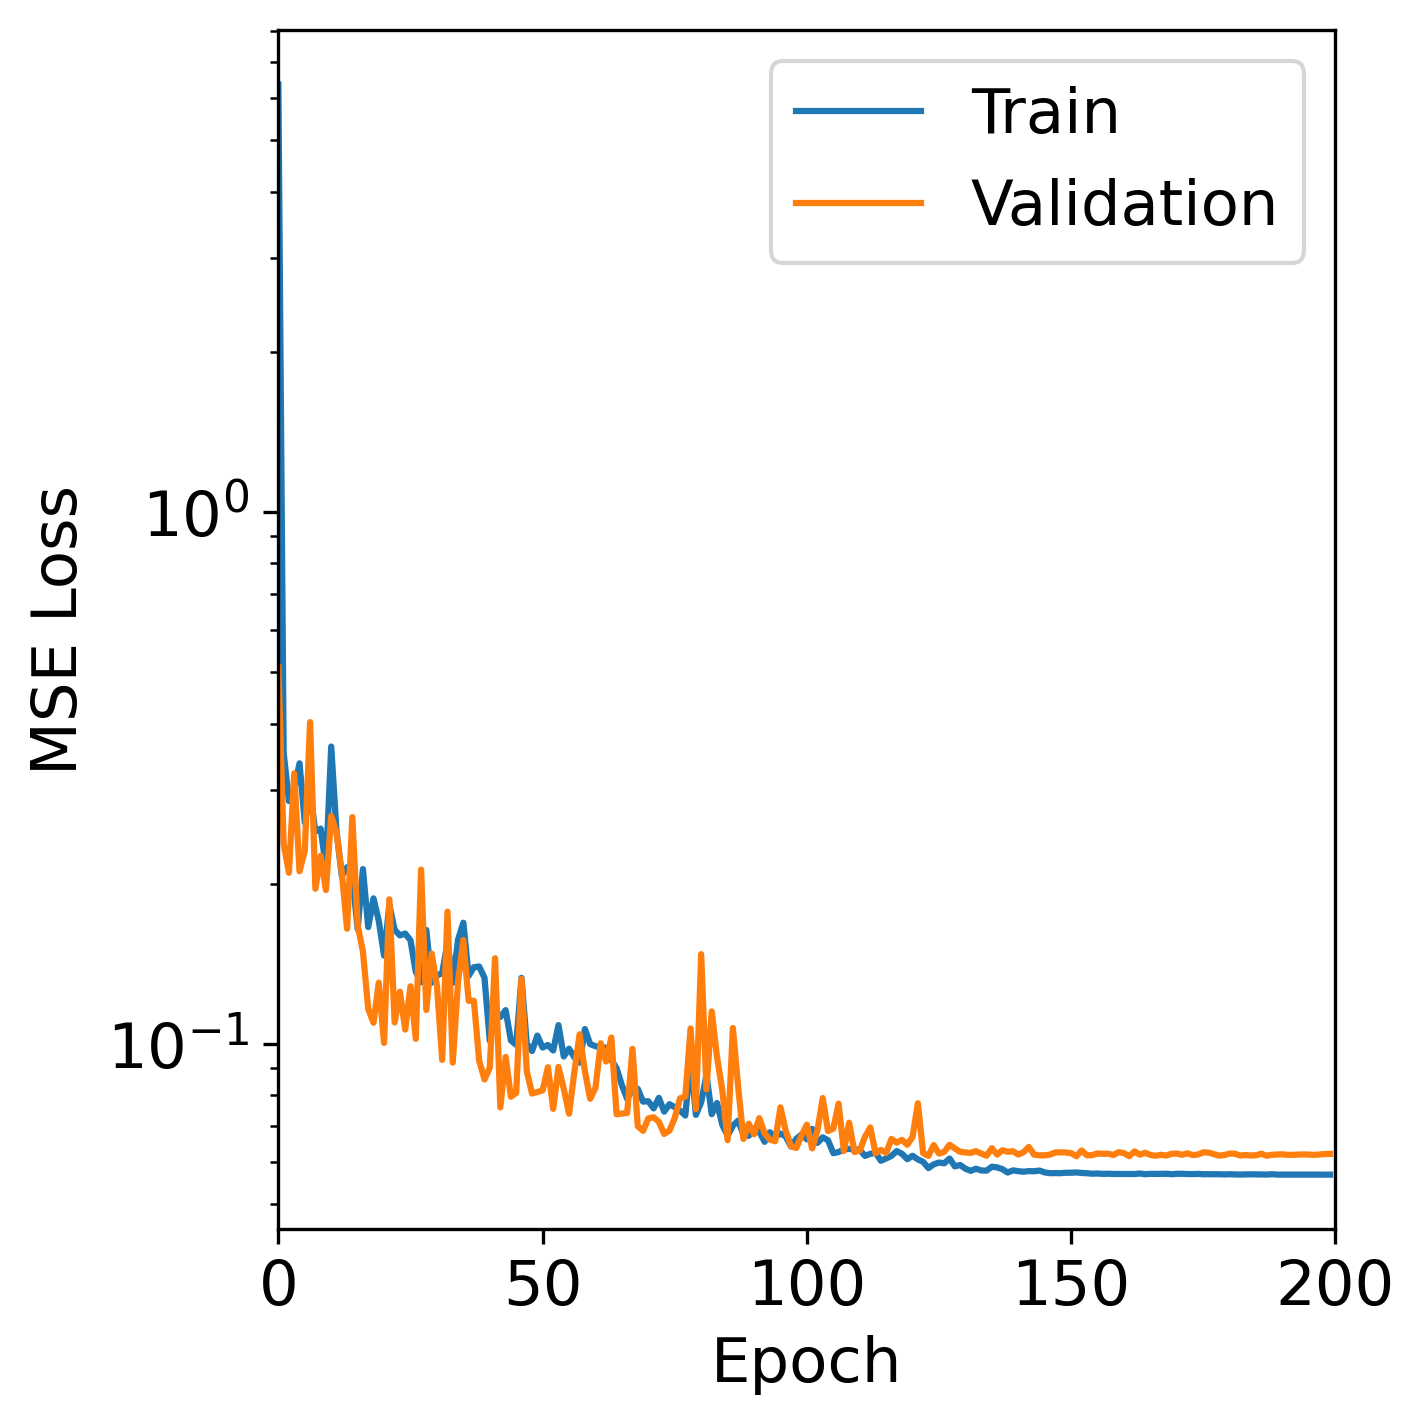

In [11]:
plt.figure(figsize=(5,5), dpi=300) 

plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 15

plt.plot(np.array(train_losses), label='Train')
plt.plot(np.array(test_losses), label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.yscale("log") 
plt.xlim(0,epoch_num)
plt.tight_layout() 

# Save model

In [12]:
best_model_path = f'{args.save_model_dir}/epoch_{args.epoch_num}.pt'  
torch.save(best_state_dict, best_model_path)

## Training and Validation data

Test R2 for E: 0.9481362700462341


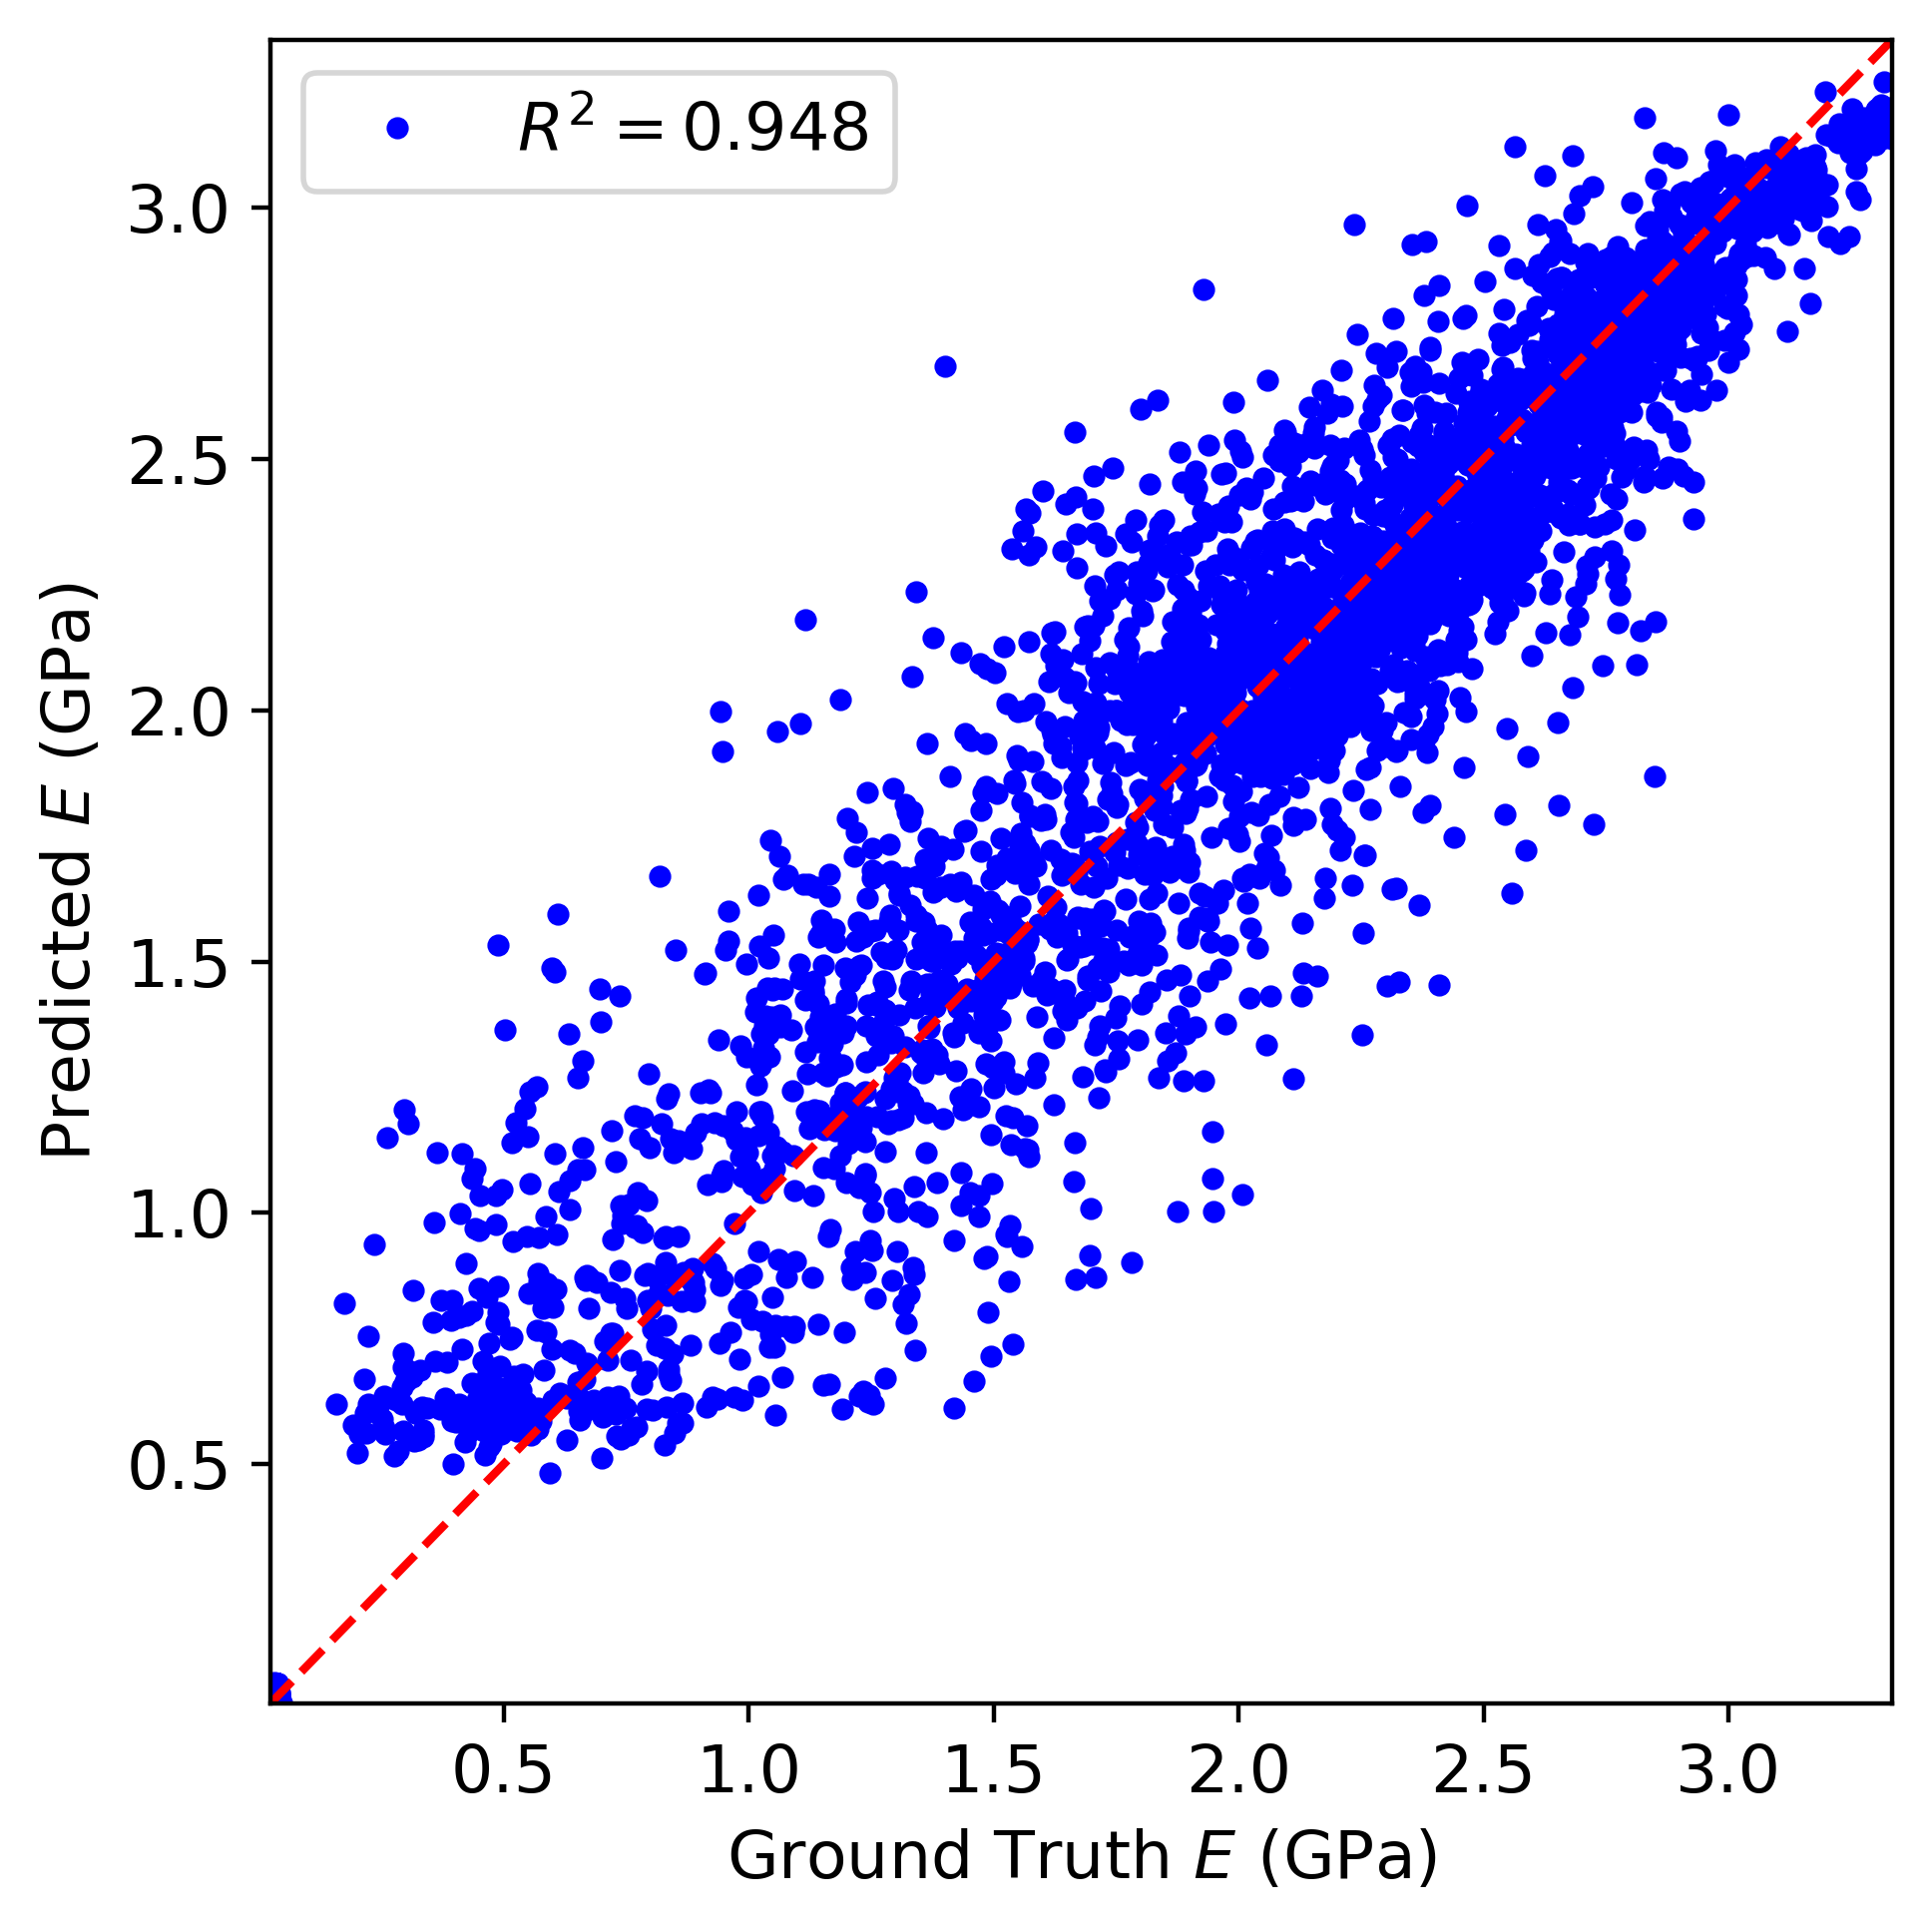

In [13]:
R2 = evaluate_model(model, train_loader, device, args.cover_interval, overlap, args.save_model_dir)

Test R2 for E: 0.942293643951416


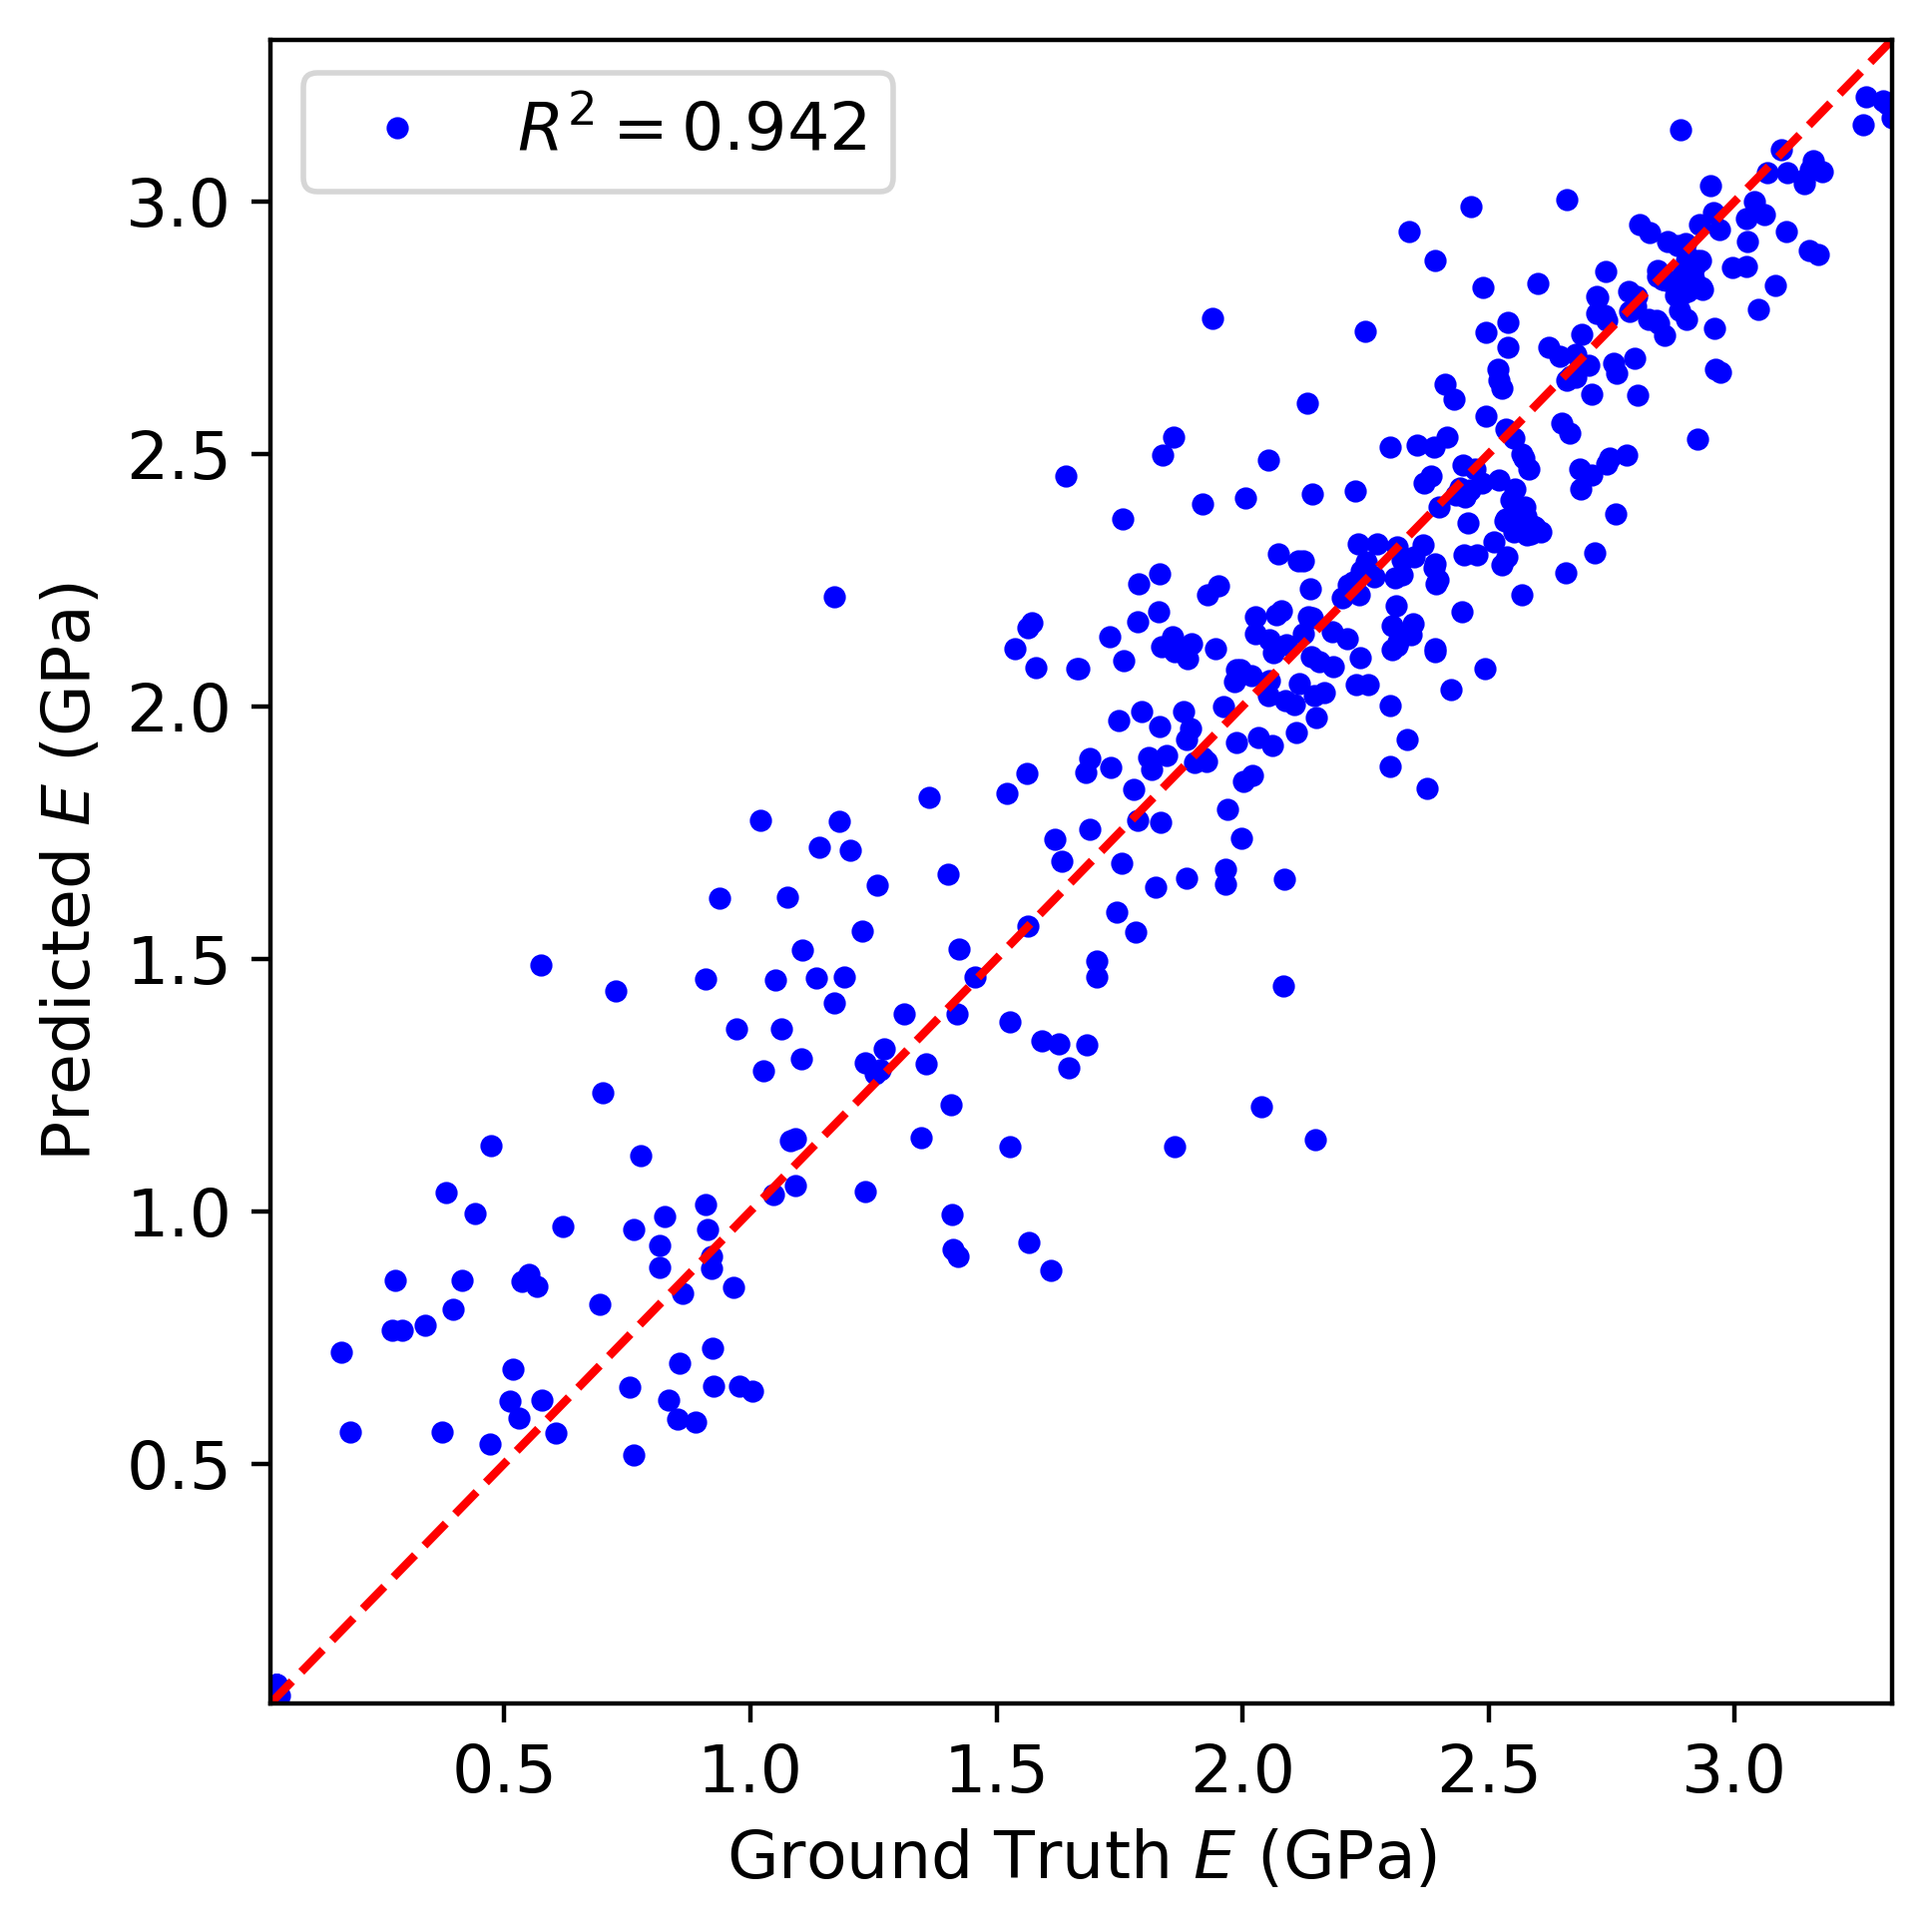

In [14]:
R2 = evaluate_model(model, test_loader, device, args.cover_interval, overlap, args.save_model_dir)

## Testing data

Test R2 for E: 0.9445675015449524


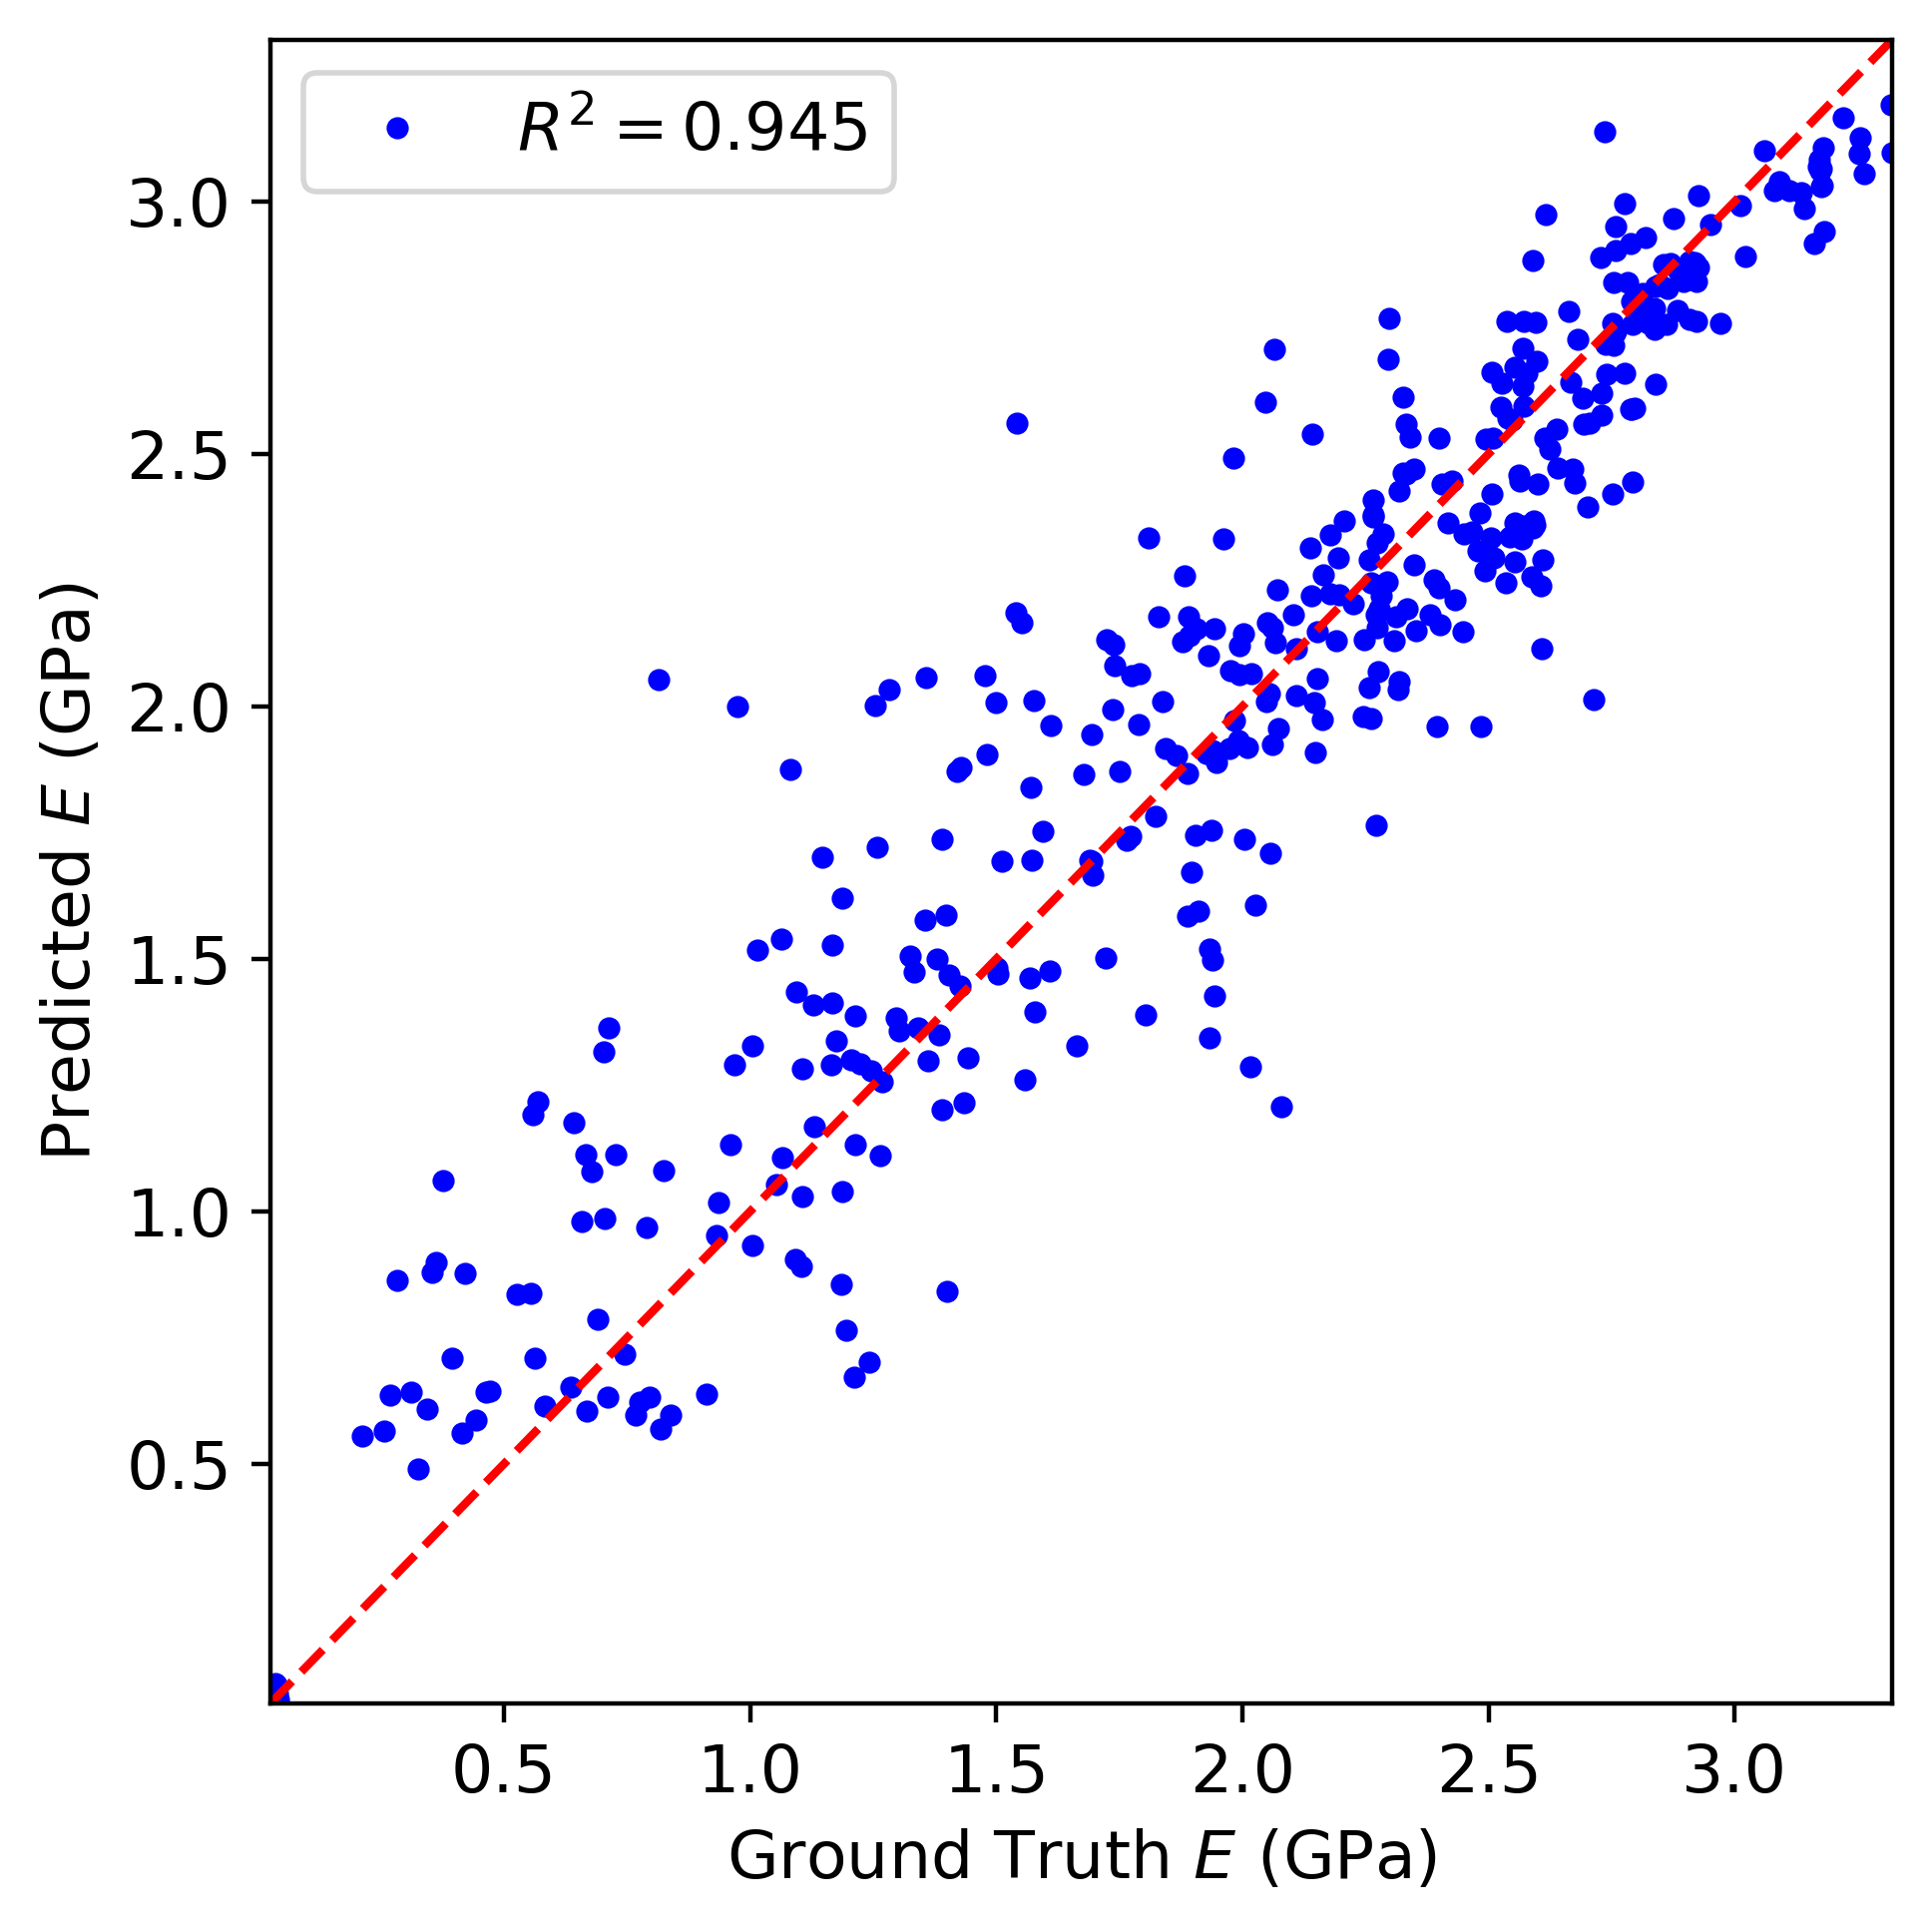

In [15]:
R2 = evaluate_model(model, valid_loader, device, args.cover_interval, overlap, args.save_model_dir)